In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rc('font', family='Malgun Gothic') # For Windows
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
  


# 데이터 불러오기
data = pd.read_csv('./data/data2015.csv')

In [2]:
# 데이터 유형 변경 및 파생변수(날짜, 시간) 생성

data['date'] = data['date'].astype('datetime64')
data['year'] = data['date'].apply(lambda x : x.year)
data['month'] = data['date'].apply(lambda x : x.month)
data['day'] = data['date'].apply(lambda x : x.day)
data['hour'] = data['date'].apply(lambda x : x.hour)
data['dow'] = data['date'].apply(lambda x : ['월', '화', '수', '목', '금', '토', '일'][x.dayofweek])

# 1. 변수들 간 상관관계 확인

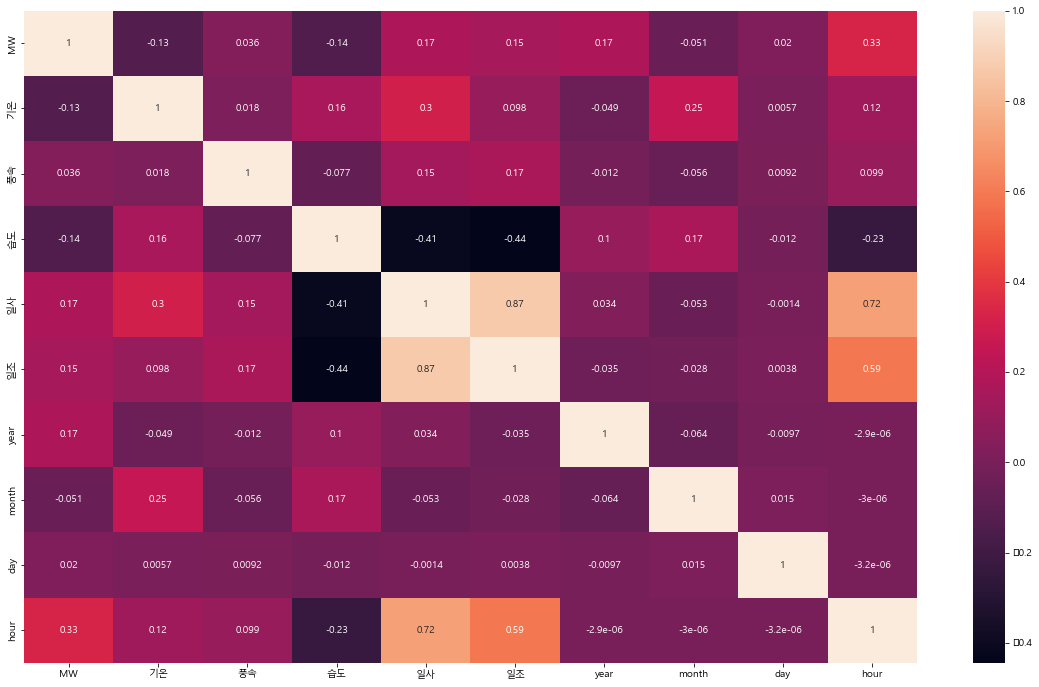

In [3]:
plt.figure(figsize = (20, 12))
sns.heatmap(data.corr(), annot=True)
plt.show()

# 2. 주기별 추세 확인

## 2.1. 연간 추세

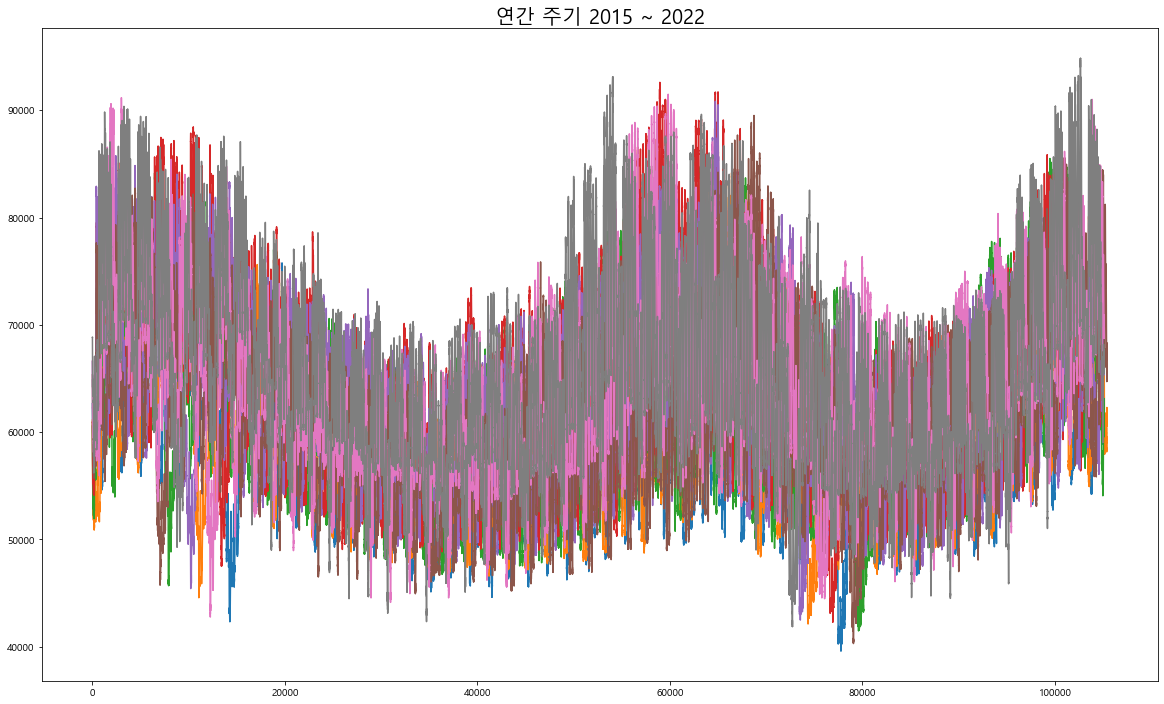

In [4]:
# plt.figure(figsize=(20, 12))
# plt.title('overlap', fontsize=20)
# for i in range(2012, 2022):
#     dd = data[data['year']==i].reset_index()
#     plt.plot(dd.data)
    
plt.figure(figsize=(20, 12))
plt.title('연간 주기 2015 ~ 2022', fontsize=20)
for i in range(2015, 2023):
    dd = data[data['year']==i]
    plt.plot(range(dd.shape[0]), dd.MW)
    
# for i in range(2015, 2023):
#     dd = data[data['year']==i]
#     plt.figure(figsize=(12, 8))
#     plt.plot(dd.date, dd.MW)

## 2.2. 주간 추세 확인

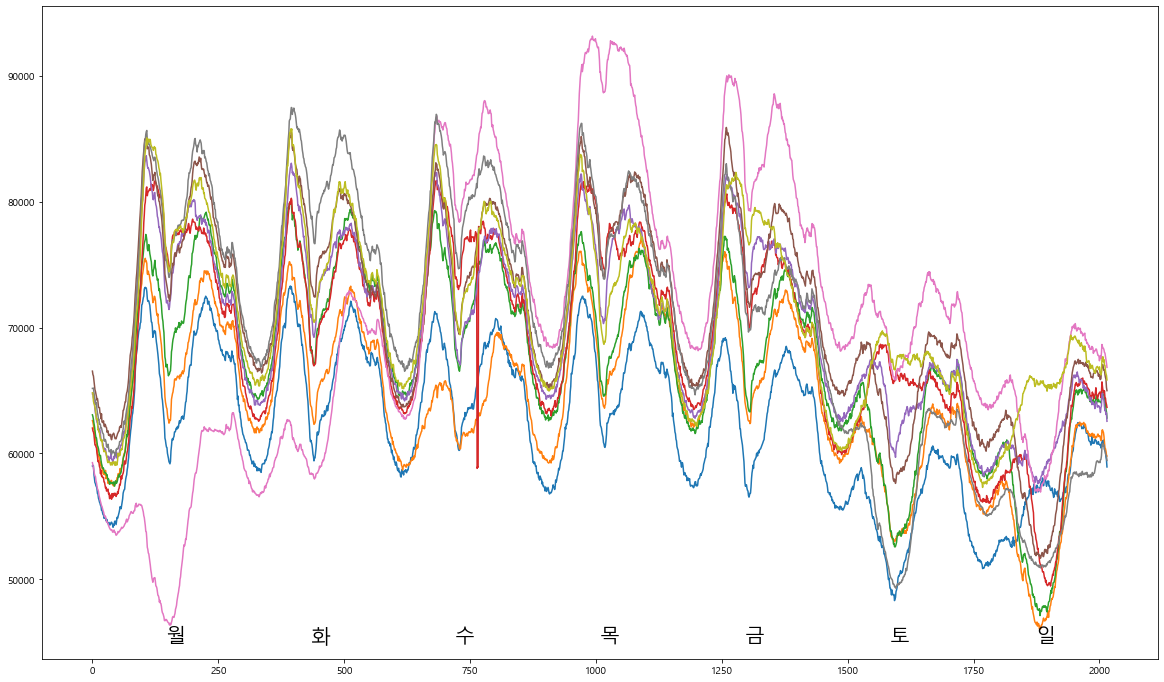

In [5]:
plt.figure(figsize=(20, 12))
plt.text(144, 45000, '월', fontsize=20)
plt.text(144+288, 45000, '화', fontsize=20)
plt.text(144+288*2, 45000, '수', fontsize=20)
plt.text(144+288*3, 45000, '목', fontsize=20)
plt.text(144+288*4, 45000, '금', fontsize=20)
plt.text(144+288*5, 45000, '토', fontsize=20)
plt.text(144+288*6, 45000, '일', fontsize=20)
for i in range(1, 10):
    plt.plot(range(2016), data.iloc[-2016*(i+1):-2016*i].MW)

# 3. 정상성 검증

In [6]:
df = data[data['date']>'2022']
df = df[df['date']<'2023']

In [7]:
from statsmodels.tsa.stattools import adfuller

# ADF (Augmented Dickey Fuller) 검정

def adf_test(x) :
    indices = ['Test Statistics', 'p-value', '# of Lags Used', '# of Observations Used']

      # AIC = 고려된 지연 수(lags)를 AIC(Akaike Information Criterion) 기반 자동 선택
    adf_test = adfuller(x, autolag = 'AIC')
    results = pd.Series(adf_test[0:4], index = indices)

    for key, value in adf_test[4].items() :
        results[f'Critical Value ({key})'] = value

    return results
  
adf_test(df.MW)

Test Statistics          -1.738375e+01
p-value                   5.055411e-30
# of Lags Used            6.900000e+01
# of Observations Used    1.050490e+05
Critical Value (1%)      -3.430412e+00
Critical Value (5%)      -2.861568e+00
Critical Value (10%)     -2.566785e+00
dtype: float64

# 4. 이동평균 모형 확인

In [8]:
ma = data[['date', 'MW']]

ma['1hour_MA'] = ma[["MW"]].rolling(window=12).mean().shift(1)
ma['6hour_MA'] = ma[["MW"]].rolling(72).mean().shift(1)
ma['1Day_MA'] = ma[["MW"]].rolling(288).mean().shift(1)
ma['1Week_MA'] = ma[["MW"]].rolling(2016).mean().shift(1)

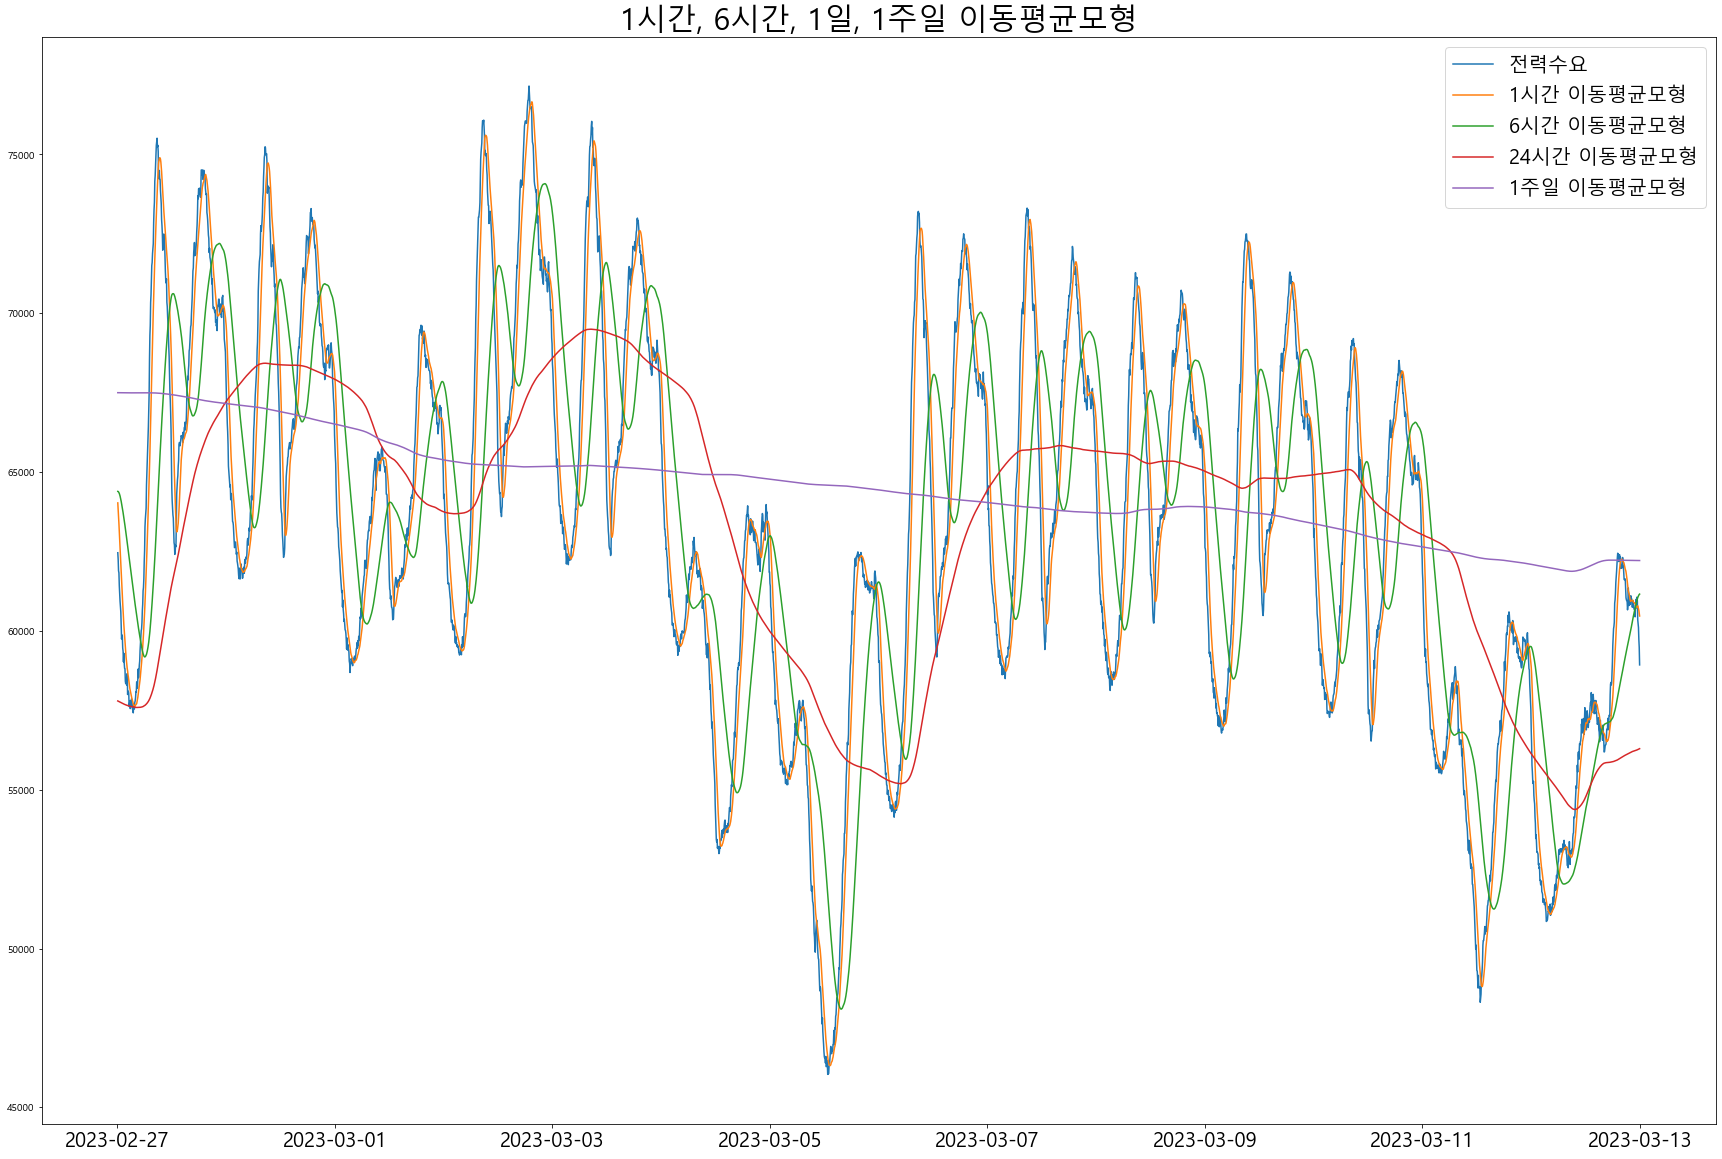

In [9]:
df = ma[ma['date']>'2023-02-27']
df = df[df['date']<'2023-03-13']

plt.figure(figsize=(30, 20))
plt.title('1시간, 6시간, 1일, 1주일 이동평균모형', fontsize=30)
plt.plot(df.date, df['MW'], label='전력수요')
plt.plot(df.date, df['1hour_MA'], label='1시간 이동평균모형')
plt.plot(df.date, df['6hour_MA'], label='6시간 이동평균모형')
plt.plot(df.date, df['1Day_MA'], label='24시간 이동평균모형')
plt.plot(df.date, df['1Week_MA'], label='1주일 이동평균모형')
plt.xticks(fontsize=20)
plt.legend(fontsize=20)